Please note that this tutorial covers the technical details
of kESI implementation.  If you are already familiar with them,
you may want to consider running its simplified version
_tutorial\_four\_spheres.ipynb_ instead.

# Model

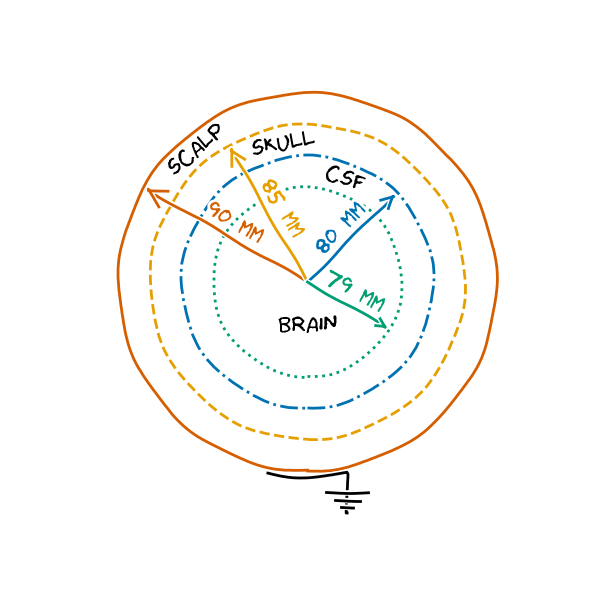

| Volume | Conductivity |
|:-------|:-------------|
| Scalp  |  330 mS / m  |
| Skull  | 16.5 mS / m  |
| CSF    | 1560 mS / m  |
| Brain  |  330 mS / m  |

# Requirements

## Memory

The code of the notebook requires at least 7.0 GB (6.6 GiB) of free memory.


## Environment

1. Anaconda Python distribution (tested with _Miniconda3-py39\_4.12.0-Linux-x86\_64.sh_, _conda v. 4.12.0_).
2. Jupyter server (see _extras/jupyter\_server.sh_ for details).
3. Anaconda environments (run _setup\_conda\_envs.sh_).
4. gmsh (not necessary if you already have meshes in either MSH or XDMF format).


## Setup

### Mesh

You need to have a mesh in XDMF format.  Try:

    conda activate kesi37
    cd extras
    snakemake data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf -j 1

# TODO BELOW

It may take a while.  At least 5.3 GB (5 GiB) of free memory is necessary.

Now you have the following files created:
- _meshes/four\_spheres\_csf\_1\_mm\_plain/normal.xdmf_,
- _meshes/four\_spheres\_csf\_1\_mm\_plain/normal.h5_,
- _meshes/four\_spheres\_csf\_1\_mm\_plain/normal\_boundaries.xdmf_,
- _meshes/four\_spheres\_csf\_1\_mm\_plain/normal\_boundaries.h5_,
- _meshes/four\_spheres\_csf\_1\_mm\_plain/normal\_subdomains.xdmf_, and
- _meshes/four\_spheres\_csf\_1\_mm\_plain/normal\_subdomains.h5_

(_\*.xdmf_ files are headers for _\*.h5_ files).  The files are derived from _meshes/four\_spheres\_csf\_1\_mm\_plain/normal.msh_ mesh saved in _gmsh_ format, which is created from blueprint in the _meshes/four\_spheres\_csf\_1\_mm\_plain/normal.geo_.  The blueprint itself is derived from a template _four\_spheres\_csf\_1\_mm\_plain.geo.template_.

The template may also be used to derive meshes of other resolutions:
- _meshes/four\_spheres\_csf\_1\_mm\_plain/finest.xdmf_,
- _meshes/four\_spheres\_csf\_1\_mm\_plain/finer.xdmf_,
- _meshes/four\_spheres\_csf\_1\_mm\_plain/fine.xdmf_,
- _meshes/four\_spheres\_csf\_1\_mm\_plain/coarse.xdmf_,
- _meshes/four\_spheres\_csf\_1\_mm\_plain/coarser.xdmf_, and
- _meshes/four\_spheres\_csf\_1\_mm\_plain/coarsest.xdmf_,

For four sphere geometry there are also templates:
- _four\_spheres\_csf\_1\_mm\_composite.geo.template_ (with more complex mesh structure),
- _four\_spheres\_csf\_1\_mm\_separate\_cortex\_composite.geo.template_ (with more complex mesh structure and cortex defined as a separate volume), and
- _four\_spheres\_csf\_3\_mm\_plain.geo.template_ (with thicker layer of cerebrospinal fluid).

### Model properties

For every mesh additional information is necessary, like conductivity of its compartments.  Such information is stored in the following files (appropriate for the tutorial marked in bold) in the _extras/FEM/model\_properties_ directory:
- _circular\_slice.ini_,
- _single\_sphere.ini_,
- **_four\_spheres\_csf\_1\_mm.ini_**,
- _four\_spheres\_csf\_1\_mm\_separate\_cortex.ini_, and
- _four\_spheres\_csf\_3\_mm.ini_.


Format of such file is:

    [<compartment name>]
    volume = <volume number>
    conductivity = <conductivity in SI units>
    
for a compartment and:

    [<surface name>]
    surface = <surface number>
    
for a boundary.  Additional information may be provided, like radius, thickness, or conductivity associated with external surface for subtraction method.

### Electrodes

In the _extras/FEM/electrode\_locations_ you can find examplary positions of electrodes in appropriate sections of INI files:

    [<electrode name>]
    x = <X coordinate in meters>
    y = <Y coordinate in meters>
    z = <Z coordinate in meters>

Lets define positions of three point electrodes:

    [first]
    x = 0
    y = 0
    z = 0.0785
    
    [second]
    x = 0.01
    y = 0
    z = 0.07
    
    [third]
    x = 0.01
    y = 0.01
    z = 0.07

Write the positions as _extras/data/bundled/electrode\_locations/tutorial/four\_spheres.ini_.

# Preprocessing

## Calculation of the leadfield correction

For every electrode we use Finite Element Method (FEM) to calculate the leadfield correction (at least 5.5 GB of free RAM is required):

    cd extras
    mkdir -p data/generated/tutorial/four_spheres/fenics_leadfield_corrections
    python solve_sphere_on_plate.py \
      --mesh data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf \
      --degree 1 \
      --config data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini \
      --grounded-plate-edge-z -0.088 \
      --electrodes data/bundled/electrode_locations/tutorial/four_spheres.ini \
      --name first \
      --output data/generated/tutorial/four_spheres/fenics_leadfield_corrections/first.ini
    python solve_sphere_on_plate.py \
      --mesh data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf \
      --degree 1 \
      --config data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini \
      --grounded-plate-edge-z -0.088 \
      --electrodes data/bundled/electrode_locations/tutorial/four_spheres.ini \
      --name second \
      --output data/generated/tutorial/four_spheres/fenics_leadfield_corrections/second.ini
    python solve_sphere_on_plate.py \
      --mesh data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf \
      --degree 1 \
      --config data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini \
      --grounded-plate-edge-z -0.088 \
      --electrodes data/bundled/electrode_locations/tutorial/four_spheres.ini \
      --name third \
      --output data/generated/tutorial/four_spheres/fenics_leadfield_corrections/third.ini

> Note, that for spherical geometries a dedicated tool
> `solve_sphere_on_plate.py` is used, with an
> additional parameter `--grounded-plate-edge-z`.

| Parameter  | Description  |
|:------------|:--------------|
| `--mesh`   | FEM mesh |
| `--degree` | degree of FEM elements |
| `--config` | physical model configuration (conductivity of subdomains etc.) |
| `--grounded-plate-edge-z` | Z-coordinate of the edge of the grounded plate |
| `--electrodes` | definition of electrode positions |
| `--name` | name of the electrode for which leadfield correction is to be calculated |
| `--output` | _\*.ini_ file for solution metadata (path to the file with the calculated function is the same up to the _\*.h5_ extension) |

## Sampling of the leadfield correction

We sample the correction on NxNxN grid, where `N = 2**K + 1`:

    mkdir -p data/generated/tutorial/four_spheres/sampled_leadfield_corrections
    python create_grid.py \
      --grid data/generated/tutorial/four_spheres/sampled_leadfield_corrections/grid.npz \
      --start -0.079 \
      --end 0.079 \
      -k 9
    python sample_spherical_solution.py \
      --fill 0 \
      --sampling-radius 0.079 \
      --grid data/generated/tutorial/four_spheres/sampled_leadfield_corrections/grid.npz \
      --config data/generated/tutorial/four_spheres/fenics_leadfield_corrections/first.ini \
      --output data/generated/tutorial/four_spheres/sampled_leadfield_corrections/first.npz
    python sample_spherical_solution.py \
      --fill 0 \
      --sampling-radius 0.079 \
      --grid data/generated/tutorial/four_spheres/sampled_leadfield_corrections/grid.npz \
      --config data/generated/tutorial/four_spheres/fenics_leadfield_corrections/second.ini \
      --output data/generated/tutorial/four_spheres/sampled_leadfield_corrections/second.npz
    python sample_spherical_solution.py \
      --fill 0 \
      --sampling-radius 0.079 \
      --grid data/generated/tutorial/four_spheres/sampled_leadfield_corrections/grid.npz \
      --config data/generated/tutorial/four_spheres/fenics_leadfield_corrections/third.ini \
      --output data/generated/tutorial/four_spheres/sampled_leadfield_corrections/third.npz

It may take several hours (at least 6.1 GB of free RAM is required).

> Note, that for spherical geometries a dedicated tool
> `sample_spherical_solution.py` is used.

| Parameter  | Description  |
|:------------|:--------------|
| `-k`   | binary logarithm of sample number in each dimansion (which is `2**k + 1`) |
| `--fill` | fill value for points where solution cannot be sampled |
| `--sampling-radius` | radius of the sampled sphere |
| `--config` | the solution metadata |
| `--output` | file for the sampled solution |

# FRR: Fast Reciprocal Reconstructor kernel construction tools

The `_fast_reciprocal_reconstructor` module contains tools which allow for fast construction of (cross)kernels.  They use discrete Fourier transform (FFT) for high throughput integration.

## Electrode object

An electrode object contains information about electrode spatial location (`.x`, `.y` and `.z` attribute), which is an absolute minimum to be used by kESI (in this case: kCSD with known base function in potential space).  It may also provide additional information about:
- leadfield (`.leadfield()` method) which enables kESI for arbitrary base function in CSD space, or
- leadfield correction (`.correction_leadfield()` method) which enables kESI for setups violating kCSD assumptions,
  while facilitating application of analitically derived kCSD base functions to avoid significant numerical errors,
- base conductivity (`.base_conductivity` attribute) assumed when calculating the leadfield correction,
- grid used to sample the leadfield correction (`.SAMPLING_GRID` attribute).

In [ ]:
import numpy as np
import scipy.interpolate as si


class Electrode(object):
    def __init__(self, filename, dx=0):
        """
        Parameters
        ----------
        
        filename : str
            Path to the sampled correction potential.
            
        dx : float
            Integration step used to calculate a regularization
            parameter of the `.leadfield()` method.
        """
        self.filename = filename
        self.dx = dx
        with np.load(filename) as fh:
            self.SAMPLING_GRID = [fh[c].flatten() for c in "XYZ"]
            self.x, self.y, self.z = fh["LOCATION"]
            self.conductivity = fh["BASE_CONDUCTIVITY"]

    @property
    def _epsilon(self):
        """
        Regularization parameter of the `.leadfield()` method.
        
        Note
        ----
        
        The 0.15 factor choice has been based on a toy numerical experiment.
        Further, more rigorous experiments are definitely recommended.
        """
        return 0.15 * self.dx

    def correction_leadfield(self, X, Y, Z):
        """
        Correction of the leadfield of the electrode
        for violation of kCSD assumptions
        
        Parameters
        ----------
        X, Y, Z : np.array
            Coordinate matrices of the same shape.
        """
        with np.load(self.filename) as fh:
            return self._correction_leadfield(fh["CORRECTION_POTENTIAL"],
                                              [X, Y, Z])

    def _correction_leadfield(self, SAMPLES, XYZ):
        return self._interpolate(SAMPLES, XYZ)
        # # if XYZ points are in nodes of the sampling grid,
        # # no time-consuming interpolation is necessary
        # return SAMPLES[self._sampling_grid_indices(XYZ)]

    def _interpolate(self, SAMPLES, XYZ):
        interpolator = si.RegularGridInterpolator(
                              self.SAMPLING_GRID,
                              SAMPLES,
                              bounds_error=False,
                              fill_value=0,
                              method=self.interpolation_method)
        return interpolator(np.stack(XYZ, axis=-1))
    
    interpolation_method = "linear"
    # The interpolation can be speeded up at the cost
    # of precision by changing the method to "nearest"
#
#     def _sampling_grid_indices(self, XYZ):
#         return tuple(np.searchsorted(GRID, COORD)
#                      for GRID, COORD in zip(self.SAMPLING_GRID, XYZ))

    def leadfield(self, X, Y, Z):
        """
        Regularized leadfield of the electrode in infinite homogenous
        isotropic medium (kCSD assumptions) of conductivity
        `.conductivity` S/m.
        
        Note
        ----
        
        The regularization is necessary to limit numerical integration
        errors.
        """
        return (0.25 / (np.pi * self.conductivity)
                / (self._epsilon
                   + np.sqrt(np.square(X - self.x)
                             + np.square(Y - self.y)
                             + np.square(Z - self.z))))

In [ ]:
electrodes = [Electrode(f'FEM/solutions/tutorial/four_spheres/sampled/9/{name}.npz')
              for name in ['first', 'second', 'third']]

## Source objects

kESI (and its special case kCSD) reconstructs CSD as a mixture of base functions (in short: _bases_).  FRR tools derive all bases as translation of an appropriate model base (with centroid at the origin of the coordinate system: $[0, 0, 0]$).

While FRR tools operate on base profiles defined as callables accepting vector arguments x, y and z, we can use a convenience kCSD base object (of either `SphericalSplineSourceKCSD` or `GaussianSourceKCSD3D` class) which couple functions in potential and CSD space.  The object is named _source_, as it represents potential (`.potential()` method) generated by certain CSD profile (`.csd()` method) in infinite homogeneous isotropic (kCSD assumptions) medium.

### Gaussian source

To familiarize with kCSD base function objects, we create an object for CSD given by three dimensional normal distribution centered at $[-5mm, 20mm, 100mm]$ with standard deviation of $10mm$, in a medium of conductivity $0.33 S/m$.

In [ ]:
from _common_new import GaussianSourceKCSD3D

import matplotlib.pyplot as plt

import cbf


src = GaussianSourceKCSD3D(-0.005, 0.02, 0.1,
                           standard_deviation=0.01,
                           conductivity=0.33)

print(f'centroid at ({src.x}m, {src.y}m, {src.z}m)')
print(f'medium conductivity: {src.conductivity}S/m')

As both CSD and potential have spherical symmetry (they depend on the distance to the centroid only), we plot them as functions of the distance:

In [ ]:
_X = src.x + np.linspace(0, 0.024, 1025)
_Y = src.y + np.linspace(0, 0.030, 1025)
_Z = src.z + np.linspace(0, 0.032, 1025)
_R = np.sqrt(np.square(_X - src.x)
             + np.square(_Y - src.y)
             + np.square(_Z - src.z))

_CSD = src.csd(_X, _Y, _Z)
_POTENTIAL = src.potential(_X, _Y, _Z)

plt.figure()
plt.plot(_R * 1e3, _CSD * 1e-3, color=cbf.SKY_BLUE)

for x in range(10, 50, 10):
    plt.axvline(x, ls=':', color=cbf.BLACK)

plt.xlim(0, 50)
plt.ylabel('CSD [$\\frac{pA}{mm^3}$]')
plt.xlabel('R [$mm$]')

plt.figure()
plt.plot(_R * 1e3, _POTENTIAL, color=cbf.PURPLE)

for x in range(10, 50, 10):
    plt.axvline(x, ls=':', color=cbf.BLACK)

plt.xlim(0, 50)
plt.ylabel('potential [$\mu{}V$]')
_ = plt.xlabel('R [$mm$]')

It may seem that base function in the CSD space disappears completely in distance greater than 4 standard deviations, but if we plot it in semilogarithmic axes, we can see that its support is much larger (theoretically infinite):

In [ ]:
_X = src.x + np.linspace(0, 0.24, 1025)
_Y = src.y + np.linspace(0, 0.30, 1025)
_Z = src.z + np.linspace(0, 0.32, 1025)
_R = np.sqrt(np.square(_X - src.x)
             + np.square(_Y - src.y)
             + np.square(_Z - src.z))

_CSD = src.csd(_X, _Y, _Z)

plt.figure()
plt.plot(_R * 1e3, _CSD * 1e-3, color=cbf.SKY_BLUE)

plt.xlim(0, 500)
plt.ylabel('CSD [$\\frac{pA}{mm^3}$]')
plt.xlabel('R [$mm$]')
plt.yscale('log')

Such base functions have certain (luckily minor) drawbacks:
- yield a fuzzy and (theoretically) spatially unlimited CSD reconstructions,
- require sampling the model base globally rather than locally.

It is feasible to mitigate that drawbacks by cropping the function support, which on the other hand introduces an error by design.  Luckily the error is sufferable - for example, cropping the 3D normal distribution to a sphere with radius of 3 standard deviations leads to loss of 2.9% of the distribution (0.81% if cropping to a cube).

### Spherical spline source

We can reduce the cropping error to 0 by use of CSD base functions with finite support, like functions of distance from their centroids ($r$; thus spherically symmetric), defined piecewise by polinomials (spline):

$$
\tilde{b}(r) =
\begin{cases}
 p_0(r), 0 \leq r < r_0   \\
 p_1(r), r_0 \leq r < r_1 \\
 \vdots \\
 p_n(r), r_{n-1} \leq r < r_n \\
 0, r_n \le r
\end{cases} ,
$$

where $p_i(x) = \sum_j \alpha_ij x^j$.

We are going to use the `SphericalSplineSourceKCSD` to define a model base with support of radius $R \equiv r_1$, that:
- is constant ($p_0(r) = c$) within radius $r_0 = \frac{1}{3} R$ from centroid,
- is continuous ($p_1(r_0) = c$ and $p_1(r_1) = 0$,
- has continuous derivative ($\dot{p}_1(r_0) = \dot{p}_1(r_1) = 0$, as $p_0$ and $0$ are constant),
- is normalised ($\iiint_{\mathbb{R}^3} \tilde{b}(x, y, z) dv = \int_0^R 4 \pi r^2 \tilde{b}(r) dr = 1$),

thus the coefficients of polynomials are:
$$
\begin{array}{rclcl}
\alpha_{00} & = & c , & & & \\
\alpha_{10} & = & c \, r_2^2\frac{r_2 - 3r_1}{(r_2 - r_1)^3} & = & 0 ,\\
\alpha_{11} & = & c \, 6 \frac{r_1 r_2}{(r_2 - r_1)^3} & = & c \frac{27}{4} R^{-1} ,\\
\alpha_{12} & = & -c \, 3 \frac{r_1 + r_2}{(r_2 - r_1)^3} & = & -c \frac{27}{2} R^{-2} ,\\
\alpha_{13} & = & c \frac{2}{(r_2 - r_1)^3} & = & c \frac{27}{4} R^{-3} ,\\
\end{array}
$$
up to a constant factor $c$.  We do not need to calculate the $c$ factor explicitely, as CSD base functions implemented with `SphericalSplineSourceKCSD` are normalised.  For the sake of simplicity we assume $c = 1$ when passing the coefficients to `SphericalSplineSourceKCSD`:

In [ ]:
from _common_new import SphericalSplineSourceKCSD


def get_model_source(radius):
    spline_nodes = [radius / 3, radius]
    spline_polynomial_coefficients = [[1],
                                      [0,
                                       6.75 / radius,
                                       -13.5 / radius ** 2,
                                       6.75 / radius ** 3]]
    return SphericalSplineSourceKCSD(0, 0, 0,
                                     spline_nodes,
                                     spline_polynomial_coefficients)

## Model source

We want to use CSD bases 18mm wide ($R = 9mm$).

In [ ]:
SRC_R = 9e-3

model_src = get_model_source(SRC_R)
print(f'centroid at ({model_src.x}m, {model_src.y}m, {model_src.z}m)')
print(f'conductivity = {model_src.conductivity}')
print(f'c = {model_src.csd(0, 0, 0):.2e}')

In [ ]:
_X = np.linspace(0, 4/3 * SRC_R, 1025)

_CSD = model_src.csd(_X, 0, 0)
_POTENTIAL = model_src.potential(_X, 0, 0)

plt.figure()
plt.plot(_X * 1e3, _CSD * 1e-6, color=cbf.SKY_BLUE)

for x in range(3, 12, 3):
    plt.axvline(x, ls=':', color=cbf.BLACK)

plt.xlim(0, 12)
plt.ylabel('CSD [$\\frac{nA}{mm^3}$]')
plt.xlabel('R [$mm$]')

plt.figure()
plt.plot(_X * 1e3, _POTENTIAL, color=cbf.PURPLE)

for x in range(3, 12, 3):
    plt.axvline(x, ls=':', color=cbf.BLACK)

plt.xlim(0, 12)
plt.ylabel('potential [$\mu{}V$]')
_ = plt.xlabel('R [$mm$]')

We can test whether the model CSD base function is normalised to $1\mu{}A$ by integrating it:

In [ ]:
from scipy.integrate import romb


_k = 8
_X = np.linspace(-SRC_R, SRC_R, 2**_k + 1)
_dx = SRC_R / 2**(_k - 1)
_SAMPLES = model_src.csd(_X.reshape(-1, 1, 1),
                         _X.reshape(1, -1, 1),
                         _X.reshape(1, 1, -1))
print(romb(romb(romb(_SAMPLES, dx=_dx), dx=_dx), dx=_dx),
      '\u03BCA')
del _SAMPLES

## Convolver object

The convolver is the engine of the FRR tools.  It is used to:
- integrate leadfields weighted by a CSD profile,
- obtain CSD profile of a mixture of base functions.

The convolver operates on three regular 3D grids of coordinates:
- _POT_ grid used for leadfield (_reciprocal potential_) integration,
- _CSD_ grid used for CSD profile calculation,
- _SRC_ grid used for distributing of base function centroids.

The _SRC_ grid is an intersection (in the set operation sense) of the _POT_ and the _CSD_ grids, thus they define the convolver unequivocally.

As convolver will use the Romberg method for integration ($2^k + 1$ quadrature nodes), the integrated CSD profile will be cropped to $2^{k - 1} h$ from centroid in every dimension, where $h$ is the quadrature step size (distance between adjacent _POT_ grid nodes).  To avoid errors by design, we want $h \geq 2^{1 - k} R$.

In [ ]:
from _fast_reciprocal_reconstructor import Convolver


BRAIN_RADIUS = 0.079
ROMBERG_K = 5

_h_min = SRC_R * 2**(1 - ROMBERG_K)
_X = _Y = np.linspace(-BRAIN_RADIUS, BRAIN_RADIUS, int(np.floor(2 * BRAIN_RADIUS / _h_min)) + 1)
_Z = np.linspace(-SRC_R, BRAIN_RADIUS, int(np.floor((BRAIN_RADIUS + SRC_R) / _h_min)) + 1)

_pot_grid = [_X, _Y, _Z]
_csd_grid = [_X, _Y, _Z[_Z >= 0]]

convolver = Convolver(_pot_grid, _csd_grid)

for _h in convolver.steps('POT'):
    assert _h >= _h_min, f'{_h} < {_h_min}'

In [ ]:
print(convolver.csd_shape)

In [ ]:
for name in ['POT', 'CSD', 'SRC']:
    print(f'{name} grid')
    print('  shape:', convolver.shape(name))
    print('  spacing:', convolver.steps(name))

Open 3D meshgrids may be accessed as `.{NAME}_GRID` attributes, where `{NAME}` is the name of the mesh.
Components of each meshgrid may be accessed as `.{NAME}_{C}` attributes, where `{C}` is the name of the coordinate.

## Convolver interface

The convolver interface binds the convolver to:
- a CSD profile,
- weights of a quadrature of equally-spaced nodes,
- boolean mask of nodes of the _SRC_ grid with centroids of the base functions.

We derive quadrature weights by applying Romberg's method to identity matrix ($2^k +1$ one-hot vectors), which yields the effective weights used by the method.

When analytical solution of the kCSD forward problem is used coupled with numeric potential correction, the domain of CSD used for calculation of the potential correction is limited to the support of the leadfield correction.  Thus, close to the support boundary the numeric correction is calculated for different CSD profile than was used for the corrected analytical solution.  To avoid errors, it is advised not to put centroids near the boundary of the support (which is a subset of the _POT_ grid).  It is also advised to limit supports of CSD bases to where current sources are biologically possible (here we include only CSD bases which supports fit in the brain).

We require centroids of bases to lie in the upper hemisphere.

In [ ]:
from _fast_reciprocal_reconstructor import ConvolverInterfaceIndexed

from scipy.integrate import romb


ROMBERG_N = 2 ** ROMBERG_K + 1
ROMBERG_WEIGHTS = romb(np.identity(ROMBERG_N), dx=2 ** -ROMBERG_K)

SRC_MASK = ((convolver.SRC_Z > 0)
            & (np.sqrt(np.square(convolver.SRC_X)
                       + np.square(convolver.SRC_Y)
                       + np.square(convolver.SRC_Z)) < BRAIN_RADIUS - SRC_R))

In [ ]:
print(SRC_MASK.sum())

In [ ]:
convolver_interface = ConvolverInterfaceIndexed(convolver,
                                                model_src.csd,
                                                ROMBERG_WEIGHTS,
                                                SRC_MASK)

## Potential At Electrode object

In [What we can and what we cannot see with extracellular multielectrodes](https://doi.org/10.1371/journal.pcbi.1008615) we have defined a $M$-dimensional feature vector $\Phi(x)$ as a function of physical space:
$$
 \Phi(x)
 = [b_1(x), \ldots, b_M(x)]^T ,
$$
representing every point $x$ by values of potential base functions there.

The $\Phi(x)$ function is implemented as a Potential At Electrode (PAE) object.  The object calculates values of potential base functions from (not all sources of information must be used):
- coordinates of their centroids (in `convolver_interface`),
- model CSD base (in `convolver_interface`),
- model potential base (a callable given as a parameter of the object's constructor),
- electrode location (in the electrode object),
- additional information (in the electrode object).

### Potential At Electrode: analytical solution of the forward problem (kCSD)

If the model potential base is known for certain assumptions (e.g. these of kCSD) which are considered met, then `PAE_Analytical` class can be used.  It strightforwardly calculates values of potential base functions from:
- coordinates of their centroids (in `convolver_interface`),
- model potential base (a callable given as a parameter of the object's constructor),
- electrode location (in the electrode object).

In [ ]:
import _fast_reciprocal_reconstructor.potential_basis_functions as pbf

In [ ]:
pbf_kcsd = pbf.Analytical(convolver_interface,
                          potential=model_src.potential)

### Potential At Electrode: purely numerical solution of the forward problem (kCSD/kESI)

If the model potential base is unknown, but leadfields of electrodes can be calculated in nodes of the _POT_ grid, then `PAE_Numerical` class can be used.  It numerically calculates values of potential base functions numerically from:
- coordinates of their centroids (in `convolver_interface`),
- model CSD base (in `convolver_interface`),
- leadfield of the electrode (`.leadfield()` method of the electrode object).

Note, that if the leadfield is not regular enough, significant numerical errors are expected.

In [ ]:
pbf_numerical = pbf.Numerical(convolver_interface)

We are not going to use that PAE object in the tutorial.

### Potential At Electrode: numerically corrected analytical solution of the forward problem (kESI)

If the model potential base is known for certain assumptions (e.g. these of kCSD) which are not met, but corrections of leadfields of electrodes can be calculated in nodes of the _POT_ nodes, then `PAE_AnalyticalCorrectedNumerically` class can be used.  It calculates values of potential base functions from:
- coordinates of their centroids (in `convolver_interface`),
- model CSD base (in `convolver_interface`),
- model potential base (a callable given as a parameter of the object's constructor),
- electrode location (in the electrode object),
- correction of the leadfield of the electrode (`.correction_leadfield()` method of the electrode object).

As the leadfield correction is often more regular than the leadfield itself, numerical errors are smaller than in purely numerical approach.

In [ ]:
pbf_kesi = pbf.AnalyticalCorrectedNumerically(convolver_interface,
                                              potential=model_src.potential)

## Kernel constructor and cross-kernel constructor

The kernel constructor is an object which is a collection of callables (methods) facilitating construction of base function values at electrodes ($\mathbf{\Phi}~=~[\Phi(x_1), \ldots, \Phi(x_N)]$, where $x_i$ is the position of the $i$-th electrode) and the kernel matrix ($\mathbf{K}~=~\mathbf{\Phi}^T\mathbf{\Phi}$).

The methods are:
- `.potential_basis_functions_at_electrodes()`  which constructs $\mathbf{\Phi}$ from a sequence of electrode objects and a _PAE_ (Potential At Electrode) object responsible for base functions in the potential space,
- `.kernel()` which constructs the kernel matrix from $\mathbf{\Phi}$.

In [ ]:
from _fast_reciprocal_reconstructor import KernelConstructor, CrossKernelConstructor

In [ ]:
kernel_constructor = KernelConstructor()

To calculate the cross-kernel matrix we need to select nodes of the _CSD_ grid
at which the CSD is to be reconstructed.
For that purpose we define a boolean mask `CSD_MASK`.  We select all nodes:

In [ ]:
CSD_MASK = np.ones(convolver.shape('CSD'),
                   dtype=bool)

The cross-kernel constructor is a callable which - based on the $\mathbf{\Phi}$ matrix (and `CSD_MASK`) - constructs the cross-kernel.  We assign it to `kernel_constructor.create_crosskernel` attribute to keep all kernel construction callables in one object.

In [ ]:
kernel_constructor.crosskernel = CrossKernelConstructor(convolver_interface,
                                                        CSD_MASK)

As all elements of `CSD_MASK` are true, conversion of the reconstructed CSD vector is as simple as its rearrangement to match the _CSD_ grid of `convolver`.  We define an auxilary `to_3D()` function for that purpose.

In [ ]:
def to_3D(CSD):
    return CSD.reshape(convolver.shape('CSD'))

# kCSD reconstructor

## Construction of kernels

In [ ]:
%%time
PHI_KCSD = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                      pbf_kcsd)

In [ ]:
KERNEL_KCSD = kernel_constructor.kernel(PHI_KCSD)

In [ ]:
%%time
CROSSKERNEL_KCSD = kernel_constructor.crosskernel(PHI_KCSD)

In [ ]:
del PHI_KCSD  # the array is large and no longer needed

## Reconstructor object

The reconstructor object is a wrapper arround (cross)kernel matrices
facilitating CSD reconstruction without explicit matrix operations.
It is a callable which accepts a vector of potentials as its parameter
and returns a vector of reconstructed CSD at the selected nodes
of the CSD grid.  It also accepts an optional regularization parameter
(which defaults to 0).
Additionally, the object facilitates efficient leave-one-out
cross-validation.

In [ ]:
from kesi._verbose import _CrossKernelReconstructor as Reconstructor
from kesi._engine import _LinearKernelSolver as KernelSolver

In [ ]:
reconstructor_kcsd = Reconstructor(KernelSolver(KERNEL_KCSD),
                                   CROSSKERNEL_KCSD)

# Visualisation

For data visualisation we define an auxilary class `CardinalPlaneVisualisation`.

In [ ]:
import matplotlib.pyplot as plt

import cbf


class CardinalPlaneVisualisation(object):
    SPHERE_RADII = [0.079, 0.080, 0.085, 0.090]

    def __init__(self,
                 grid,
                 plane_intersection,
                 dpi=35,
                 cmap=cbf.bwr,
                 amp=None,
                 length_factor=1,
                 length_unit='$m$',
                 unit_factor=1,
                 unit=''):
        self.grid = grid
        self.plane_intersection = np.array(plane_intersection)
        self.indices = [np.searchsorted(g, a)
                        for a, g in zip(plane_intersection,
                                        grid)]
        self.dpi = dpi
        self.cmap = cmap
        self.amp = amp
        self.length_factor = length_factor
        self.length_unit = length_unit
        self.unit_factor = unit_factor
        self.unit = unit

    def start_new_image(self, title, wx, wy, wz):
        self.fig = plt.figure(figsize=((wx + wy) / self.dpi,
                                       (wz + wy) / self.dpi))
        if title is not None:
            self.fig.suptitle(title)

        gs = plt.GridSpec(2, 2,
                          figure=self.fig,
                          width_ratios=[wx, wy],
                          height_ratios=[wz, wy])

        self.ax_xz = self.fig.add_subplot(gs[0, 0])
        self.ax_xz.set_aspect('equal')
        self.ax_xz.set_ylabel(f'Z [{self.length_unit}]')
        self.ax_xz.set_xlabel(f'X [{self.length_unit}]')

        self.ax_yx = self.fig.add_subplot(gs[1, 1])
        self.ax_yx.set_aspect('equal')
        self.ax_yx.set_ylabel(f'X [{self.length_unit}]')
        self.ax_yx.set_xlabel(f'Y [{self.length_unit}]')

        self.ax_yz = self.fig.add_subplot(gs[0, 1],
                                          sharey=self.ax_xz,
                                          sharex=self.ax_yx)
        self.ax_yz.set_aspect('equal')

        self.cax = self.fig.add_subplot(gs[1, 0])
        self.cax.set_visible(False)

    def finish_image(self):
        x, y, z = self.length_factor * self.plane_intersection

        self.ax_xz.axvline(x, ls=':', color=cbf.BLACK)
        self.ax_xz.axhline(z, ls=':', color=cbf.BLACK)

        self.ax_yx.axvline(y, ls=':', color=cbf.BLACK)
        self.ax_yx.axhline(x, ls=':', color=cbf.BLACK)

        self.ax_yz.axvline(y, ls=':', color=cbf.BLACK)
        self.ax_yz.axhline(z, ls=':', color=cbf.BLACK)
        self.fig.colorbar(self.im, ax=self.cax,
                          orientation='horizontal',
                          label=self.unit)

        self._add_spheres(self.SPHERE_RADII)

    def plot_volume(self, DATA, title=None, amp=None):
        self.start_new_image(title, *DATA.shape)
        ix, iy, iz = self.indices
        self._plot_planes([DATA[ix:ix+1, :, :],
                           DATA[:, iy:iy+1, :],
                           DATA[:, :, iz:iz+1],
                           ],
                           amp if amp is not None else abs(DATA).max())
        self.finish_image()

    def _plot_planes(self, DATA_PLANES, amp):
        DATA_ZY = DATA_PLANES[0][0, :, :].T * self.unit_factor
        DATA_ZX = DATA_PLANES[1][:, 0, :].T * self.unit_factor
        DATA_XY = DATA_PLANES[2][:, :, 0] * self.unit_factor
        
        def _extent(first, second):
            _first = self.grid[first] * self.length_factor
            _second = self.grid[second] * self.length_factor
            return (_first.min(), _first.max(),
                    _second.min(), _second.max())

        self.ax_xz.imshow(DATA_ZX,
                          vmin=-amp * self.unit_factor,
                          vmax=amp * self.unit_factor,
                          cmap=self.cmap,
                          origin='lower',
                          extent=_extent(0, 2))
        self.ax_yx.imshow(DATA_XY,
                          vmin=-amp * self.unit_factor,
                          vmax=amp * self.unit_factor,
                          cmap=self.cmap,
                          origin='lower',
                          extent=_extent(1, 0))
        self.im = self.ax_yz.imshow(DATA_ZY,
                                    vmin=-amp * self.unit_factor,
                                    vmax=amp * self.unit_factor,
                                    cmap=self.cmap,
                                    origin='lower',
                                    extent=_extent(1, 2))

    def plot_planes(self,
                    DATA_PLANES,
                    title=None,
                    amp=None):

        DATA_YZ, DATA_XZ, DATA_XY = DATA_PLANES
        wx, wy, _ = DATA_XY.shape
        wz = DATA_YZ.shape[2]
        assert DATA_YZ.shape[1] == wy
        assert DATA_XZ.shape[0] == wx
        assert DATA_XZ.shape[2] == wz
        
        self.start_new_image(title, wx, wy, wz)
        self._plot_planes(DATA_PLANES,
                          amp if amp is not None else max(abs(_A).max() for _A in DATA_PLANES))
        self.finish_image()

    def compare_with_gt(self, GT, CSD, title=''):
        ERROR = CSD - GT
        error_L2 = np.sqrt(np.square(ERROR).sum() / np.square(GT_CSD).sum())
        amp = max(abs(CSD).max(),
                  abs(GT).max(),
                  abs(ERROR).max())
        self.plot_volume(GT,
                         title='GT CSD',
                         amp=amp)
        self.plot_volume(CSD,
                         title=f'{title} reconstruction',
                         amp=amp)
        self.plot_volume(ERROR,
                         title=f'{title} error (GT normalized L2 norm: {error_L2:.2g})',
                         amp=amp)

    def _add_spheres(self, sphere_radii):
        for c, ax in zip(self.plane_intersection,
                         [self.ax_yz,
                          self.ax_xz,
                          self.ax_yx]):
            for r2 in np.square(sphere_radii):
                self._plot_circle(ax, np.sqrt(r2 - np.square(c)))

    def _plot_circle(self, ax, r):
        ax.add_artist(plt.Circle((0, 0), r * self.length_factor,
                                facecolor='none',
                                edgecolor=cbf.BLACK,
                                linestyle=':'))

    @property
    def PLANES_XYZ(self):
        return [[[c] if i == j else A for j, A in enumerate(self.grid)]
                for i, c in enumerate(self.plane_intersection)]

In [ ]:
csd_grid = [_x.flatten() for _x in convolver.CSD_GRID]

In [ ]:
csd_plotter = CardinalPlaneVisualisation(csd_grid,
                                         [0.01, 0, 0.065],
                                         unit_factor=1e-3,
                                         unit='$\\frac{pA}{mm^3}$',
                                         length_factor=1e3,
                                         length_unit='$mm$')

# Ground truth CSD and its potential at the electrodes

## GT CSD

We derive GT CSD as an eigensource (scaled by a factor) of kCSD.  The order of the returned eigenvalues (and eigenvectors) is reversed for the sake of the highest-first convention.

In [ ]:
%%time
EIGENVALUES_KCSD, EIGENVECTORS_KCSD = np.linalg.eigh(KERNEL_KCSD)
EIGENVALUES_KCSD, EIGENVECTORS_KCSD = EIGENVALUES_KCSD[::-1], EIGENVECTORS_KCSD[:, ::-1]

GT_CSD = to_3D(reconstructor_kcsd(EIGENVECTORS_KCSD[:, 0] * 10))

In [ ]:
csd_plotter.plot_volume(GT_CSD, 'GT CSD')

## FEM forward modelling

In [ ]:
import configparser
import dolfin
import scipy.interpolate as si

import FEM.fem_common as fc

We define a FEM forward model. It is a callable, which accepts CSD profile as a callable compatible with `scipy.interpolate.RegularGridInterpolator`.  Note that the model uses a different Dirichlet boundary condition than a forward model for slice geometry.

In [ ]:
class ForwardModel(object):
    # XXX: duplicated code with FEM classes
    
    GROUNDED_PLATE_AT = -0.088
    
    def __init__(self, mesh, degree, config):
        self.fm = fc.FunctionManager(mesh, degree, "CG")
        self.config = configparser.ConfigParser()
        self.config.read(config)
        
        mesh_filename = mesh[:-5]
        
        self.V = self.fm.function_space
        mesh = self.fm.mesh

        n = self.V.dim()
        d = mesh.geometry().dim()

        self.dof_coords = self.V.tabulate_dof_coordinates()
        self.dof_coords.resize((n, d))
        
        self.csd_f = self.fm.function()
        
        with dolfin.XDMFFile(mesh_filename + "_subdomains.xdmf") as fh:
            mvc = dolfin.MeshValueCollection("size_t", mesh, 3)
            fh.read(mvc, "subdomains")
            self.subdomains = dolfin.cpp.mesh.MeshFunctionSizet(mesh, mvc)
            self.dx = dolfin.Measure("dx")(subdomain_data=self.subdomains)

    @property
    def CONDUCTIVITY(self):
        for section in self.config.sections():
            if self._is_conductive_volume(section):
                yield (self.config.getint(section, "volume"),
                       self.config.getfloat(section, "conductivity"))

    def _is_conductive_volume(self, section):
        return (self.config.has_option(section, "volume")
                and self.config.has_option(section, "conductivity")) 
        
    def __call__(self, csd_interpolator):
        self.csd_f.vector()[:] = csd_interpolator(self.dof_coords)
        
        dirichlet_bc_gt = dolfin.DirichletBC(self.V,
                                     dolfin.Constant(0),
                                     (lambda x, on_boundary:
                                      on_boundary and x[2] <= self.GROUNDED_PLATE_AT))
        test = self.fm.test_function()
        trial = self.fm.trial_function()
        potential = self.fm.function()
        
        
        dx = self.dx
        a = sum(dolfin.Constant(c)
                * dolfin.inner(dolfin.grad(trial),
                               dolfin.grad(test))
                * dx(i)
                for i, c
                in self.CONDUCTIVITY)
        L = self.csd_f * test * dx
        
        b = dolfin.assemble(L)
        A = dolfin.assemble(a)
        dirichlet_bc_gt.apply(A, b)
        
        solver = dolfin.KrylovSolver("cg", "ilu")
        solver.parameters["maximum_iterations"] = 10000
        solver.parameters["absolute_tolerance"] = 1E-8
        # solver.parameters["monitor_convergence"] = True  # Goes to Jupyter server output stream
        solver.solve(A, potential.vector(), b)
        
        return potential

In [ ]:
%%time
fem = ForwardModel("data/generated/meshes/four_spheres_csf_3_mm__plain/normal.xdmf",
                   1,
                   "data/bundled/model_properties/four_spheres_csf_3_mm__Naess_Chintaluri_2017.ini")

It may take more than 3 minutes.

We simulate the potential generated by the ground truth CSD profile.

In [ ]:
%%time
_csd = si.RegularGridInterpolator(csd_grid,
                                  GT_CSD,
                                  bounds_error=False,
                                  fill_value=0)
potential = fem(_csd)

del _csd  # the object is large and no longer needed

It may take more than 2 minutes.

We probe the potential in the cardinal planes to visualise it.

In [ ]:
potential_plotter = CardinalPlaneVisualisation(csd_grid,
                                               [0.01, 0, 0.065],
                                               unit='$\mu{}V$',
                                               length_factor=1e3,
                                               length_unit='$mm$',
                                               cmap=cbf.PRGn)

In [ ]:
%%time
V_PLANES = []

for _X, _Y, _Z in potential_plotter.PLANES_XYZ:
    with np.nditer([np.reshape(_X, (-1, 1, 1)),
                    np.reshape(_Y, (1, -1, 1)),
                    np.reshape(_Z,  (1, 1, -1)),
                    None]) as it:
        for _x, _y, _z, _res in it:
            try:
                _res[...] = potential(_x, _y, _z)
            except RuntimeError:
                _res[...] = np.nan

        V_PLANES.append(np.ma.masked_invalid(it.operands[3]))

It may take more than a minute.

In [ ]:
potential_plotter.plot_planes(V_PLANES, 'POTENTIAL')

We probe the potential at electrodes.

In [ ]:
GT_V = np.array([potential(_e.x, _e.y, _e.z) for _e in electrodes])

In [ ]:
del potential, fem  # these objects are large and no longer needed

# Reconstruction

## kCSD

As the ground truth CSD is a kCSD eigensource, kCSD is (theoretically) able to reconstruct it exactly.  But the forward model does not conform to assumptions of kCSD, which may lead to reconstruction artifacts.

In [ ]:
CSD_KCSD = to_3D(reconstructor_kcsd(GT_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KCSD,
                            'kCSD')

The reconstruction is mostly error.

In [ ]:
del CSD_KCSD  # the array is large and no longer needed

In [ ]:
del reconstructor_kcsd, CROSSKERNEL_KCSD  # these objects are large and no longer needed

## kESI

kESI accounts for violation of kCSD assumptions, thus we expect more reliable reconstruction.

In [ ]:
%%time
PHI_KESI = kernel_constructor.potential_basis_functions_at_electrodes(electrodes,
                                                                      pbf_kesi)

It may take more than a minute.

In [ ]:
KERNEL_KESI = kernel_constructor.kernel(PHI_KESI)

In [ ]:
%%time
CROSSKERNEL_KESI = kernel_constructor.crosskernel(PHI_KESI)

In [ ]:
del PHI_KESI  # the array is large and no longer needed

In [ ]:
reconstructor_kesi = Reconstructor(KernelSolver(KERNEL_KESI),
                                   CROSSKERNEL_KESI)

In [ ]:
CSD_KESI = to_3D(reconstructor_kesi(GT_V))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI,
                            'kESI')

The reconstruction is pretty close to the ground truth.

In [ ]:
del CSD_KESI  # the array is large and no longer needed

## Noise

As no real-world measurement is perfect, we introduce 2% noise to see, how kESI may deal with it:

In [ ]:
np.random.seed(42)
V_WITH_NOISE = np.random.normal(loc=GT_V,
                                scale=0.02*np.sqrt(np.square(GT_V).mean()))

In [ ]:
CSD_KESI_WITH_NOISE = to_3D(reconstructor_kesi(V_WITH_NOISE))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_WITH_NOISE,
                            'kESI (noise)')

In [ ]:
del CSD_KESI_WITH_NOISE  # the array is large and no longer needed

As you can see, the quality of reconstruction decreased significatntly.

## Regularization

Mathematically, any potential vector $V$ can be seen as a linear combination of eigenvectors $v_i$ of the kernel matrix $K$:
$$
V = \sum_{i=1}^N a_i v_i ,
$$
$$
K = \sum_{i=1}^N v_i \lambda_i v_i^T ,
$$
which makes the CSD reconstruction $C$:
$$
C = \sum_{i=1}^N \frac{a_i}{\lambda_i} \tilde{v}_i ,
$$
where $\tilde{v}_i$ are eigensources.  A noisy vector $\hat{V} = V + \varepsilon$ can be seen as:
$$
\hat{V} = \sum_{i=1}^N (a_i + \varepsilon_i) v_i = V + \sum_{i=1}^N \varepsilon_i v_i ,
$$
which makes the CSD reconstruction $\hat{C}$:
$$
\hat{C} = C + \sum_{i=1}^N \frac{\varepsilon_i}{\lambda_i} \tilde{v}_i ,
$$
and the noise-related error $E$:
$$
E = \sum_{i=1}^N \frac{\varepsilon_i}{\lambda_i} \tilde{v}_i .
$$
It is clear that noise component associated with small eigenvalues ($\lambda_i$) can easily dominate the solution.

A technique called regularization limits impact of components associated with small eigenvalues by slightly modifying the solution:
$$
\hat{C}' = \sum_{i=1}^N \frac{a_i + \varepsilon_i}{\lambda_i + \lambda} \tilde{v}_i ,
$$
where $\lambda$ is the regularization parameter.  But regularization is not a silver bullet.  While it limits the noise-related error:
$$
E' = \sum_{i=1}^N \frac{\varepsilon_i}{\lambda_i + \lambda} \tilde{v}_i ,
$$
it also suppresses reconstructions of eigensources associated with small eigenvalues, as:
$$
C' = \sum_{i=1}^N \frac{a_i}{\lambda_i + \lambda} \tilde{v}_i .
$$
It is thus important to choose the regularization parameter $\lambda$ wisely.  The span of parameters from which it is being selected should cover eigenvalues of the kernel.  Values smaller than the smallest eigenvalue have negligible effect, while values larger than the largest eigenvalue suppress reconstruction completely, thus the optimal value of the regularization parameter is expected to fall in the span of eigenvalues.  If the smallest of parameters is selected, that may suggest that the solution should not be regularized.  Such suggestion is explicite if the set of tested parameters includes $0$.

In [ ]:
EIGENVALUES_KESI = np.linalg.eigvalsh(KERNEL_KESI)[::-1]

We reversed order of the returned eigenvalues for the sake of the highest-first convention.

In [ ]:
plt.plot(EIGENVALUES_KESI,
         marker='o')

plt.yscale('log')

In [ ]:
REGULARIZATION_PARAMETERS = np.logspace(4, 14, 10 * 10 + 1)

### Leave-one-out cross-validation

We select a regularization parameter which minimizes L2 norm of leave-one-out cross-validation errors.  Leave-one-out means that we predict the potential at a single (the left out) electrode from potentials at the remaining electrodes, and calculate the prediction error.  The procedure is repeated for every electrode and norm of the errors is calculated.

The convenience function `cv()` maps regularization parameters to norms of corresponding errors  (given a reconstructor and measurements).

In [ ]:
from _common_new import cv

In [ ]:
%%time
CV_ERRORS = cv(reconstructor_kesi, V_WITH_NOISE, REGULARIZATION_PARAMETERS)

In [ ]:
regularization_parameter_idx = np.argmin(CV_ERRORS)
regularization_parameter = REGULARIZATION_PARAMETERS[regularization_parameter_idx]

In [ ]:
plt.plot(REGULARIZATION_PARAMETERS,
         CV_ERRORS,
         color=cbf.BLUE)
plt.axvline(regularization_parameter,
            ls=':',
            color=cbf.BLUE)
plt.xscale('log')
plt.xlabel('regularization parameter')
plt.yscale('log')
plt.ylabel('L2 norm of cross-validation error')

In [ ]:
CSD_KESI_CV = to_3D(reconstructor_kesi(V_WITH_NOISE, regularization_parameter))

In [ ]:
csd_plotter.compare_with_gt(GT_CSD,
                            CSD_KESI_CV,
                            'kESI (noise)')

In [ ]:
del CSD_KESI_CV  # the array is large and no longer needed

### L-curve

The L-curve method is a heuristic based on observation, that for high values of $\lambda$ the solution norm (defined in eq. 26 from [What we can and what we cannot see with extracellular multielectrodes](https://doi.org/10.1371/journal.pcbi.1008615) and associated with overfitting) is low but the prediction error is high, while for low values of $\lambda$ it is the opposite.  It is assumed that for the optimal $\lambda$ both error and norm are reasonably low, and either of them quickly increases with change of $\lambda$.  Thus, when errors and norms obtained for a range of regularization parameters are plot against each other, the curve is expected to be "L"-shaped with values for the optimal parameter in the "knee" of the curve.

The regularized potential $V_{\lambda}$ is predicted from the actually measured potential $V$:
$$
V_{\lambda} = K \beta_{\lambda} ,
$$
where
$$
\beta_{\lambda} = (K + I \lambda)^{-1} V .
$$

In [ ]:
model_norm = []
error = []
for _regularization_parameter in REGULARIZATION_PARAMETERS:
    _beta = np.linalg.solve(KERNEL_KESI + _regularization_parameter * np.identity(len(electrodes)),
                            V_WITH_NOISE)
    _V = np.matmul(KERNEL_KESI, _beta)
    error.append(np.sqrt(np.square(V_WITH_NOISE - _V).mean()))
    model_norm.append(np.dot(_beta, _V))

In [ ]:
_idx_low, _idx_high = np.searchsorted(REGULARIZATION_PARAMETERS,
                                      [EIGENVALUES_KESI.min(),
                                       EIGENVALUES_KESI.max()])
_bottom = model_norm[_idx_high]
_top = model_norm[_idx_low]
_left = error[_idx_low]
_right = error[_idx_high]

fig, ax = plt.subplots()
ax.plot(error, model_norm,
        marker='.',
        color=cbf.BLUE)
ax.add_patch(plt.Rectangle((_left, _bottom),
                           _right - _left,
                           _top - _bottom,
                           ls=':',
                           edgecolor=cbf.BLACK,
                           facecolor='none'))

ax.set_yscale('log')
ax.set_ylabel('norm of the model')
ax.set_xscale('log')
ax.set_xlabel('L2 norm of the prediction error')
ax.set_title('L-curve')


fig, ax = plt.subplots()
ax.plot(error, model_norm,
        marker='.',
        color=cbf.BLUE)
ax.plot(error[regularization_parameter_idx],
        model_norm[regularization_parameter_idx],
        marker='o',
        color=cbf.VERMILION)
ax.annotate(f'$\\lambda$ = {regularization_parameter:.2e}\n(selected by CV)',
            (error[regularization_parameter_idx],
             model_norm[regularization_parameter_idx]),
            xytext=(25, -50),
            textcoords='offset points',
            arrowprops={'facecolor': cbf.BLACK,
                        'shrink': 0.1,
                        'headwidth': 6,
                        'width': 2,
                       })

ax.set_yscale('log')
ax.set_ylabel('norm of the model')
ax.set_xscale('log')
ax.set_xlabel('L2 norm of the prediction error')
ax.set_xlim(_left, _right)
ax.set_ylim(_bottom, _top)
_ = ax.set_title('L-curve cropped to the range of eigenvalues')